In [1]:
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import scipy as sp
import scipy.stats as stats
import h5py
import torch
import copy
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.manifold import MDS
from sklearn.model_selection import ShuffleSplit
import os
from google.colab import drive
import seaborn as sns

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Universal Procedure class from lecture 7
class UniversalProcedure:
    """A class to implement the universal procedure for model training and evaluation."""

    def __init__(
        self, cross_validator, evaluation_metrics=None, loss_func=None, optimizer=None
    ):

        self.cross_validator = cross_validator

        if evaluation_metrics is None:
            self.evaluation_metrics = {"Accuracy": lambda y, y_pred: (y_pred == y).float().mean() }
        else:
            self.evaluation_metrics = evaluation_metrics

        if loss_func is None:
            self.loss_func = nn.MSELoss()
        else:
            self.loss_func = loss_func

        if optimizer is None:
            self.optimizer = optim.Adam
        else:
            self.optimizer = optimizer

    def train(
        self,
        model,  # The instantiated but untrained PyTorch model
        X_train,  # The training data input
        y_train,  # The training labels (the desired output)
        train_epochs,  # How many epochs to train for
        lr,  # The learning rate to use
    ):

        # Set up optimizer and loss function from self
        optimizer = self.optimizer(model.parameters(), lr=lr)
        loss_fn = self.loss_func

        # Track losses during training
        losses = []

        # Training loop
        for epoch in tqdm(range(train_epochs), leave=False):
            # Forward pass
            y_pred = model(X_train)  # Gets the prediction

            # Compute loss
            loss = loss_fn(y_pred, y_train)  # Runs the loss function
            losses.append(loss.item())  # Appends the loss for later tracking purposes

            # Backward pass and optimize
            optimizer.zero_grad()  # To make sure gradients don't accumulate
            loss.backward()  # This actually calls the derivation calculation
            optimizer.step()  # This actually applies the update

        return losses

    def evaluate(self, model, x, y, train_epochs=500, lr=0.01):

        # Initialize results dictionary
        results = {}
        for name in self.evaluation_metrics.keys():
            results[f"splits_{name}"] = []

        # Get default params from model
        original_state_dict = copy.deepcopy(
            model.state_dict()
        )  # Save initial parameters

        # State_dict list to store trained model parameters
        state_dicts = []

        # Perform cross-validation
        for train_idx, test_idx in tqdm(self.cross_validator.split(x)):
            # Split data
            x_train, x_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Reset model parameters
            model.load_state_dict(original_state_dict)

            # Fit model
            self.train(model, x_train, y_train, train_epochs, lr)

            # Get predictions
            with torch.no_grad():
                y_test_pred = model.predict(x_test)

            # Calculate metrics
            for name, metric_fn in self.evaluation_metrics.items():
                results[f"splits_{name}"].append(metric_fn(y_test, y_test_pred))

            state_dicts.append(copy.deepcopy(model.state_dict()))

        # Average metrics across folds
        for name in self.evaluation_metrics.keys():
            results[f"CV {name}"] = np.mean(results[f"splits_{name}"])
            results[f"CV {name} Std"] = np.std(results[f"splits_{name}"])

        return results, state_dicts

In [3]:
# helper function
def ensure_bytes(input_string):
    if isinstance(input_string, bytes):
        return input_string
    elif isinstance(input_string, str):
        return input_string.encode("utf-8")
    else:
        raise TypeError(f"Expected str or bytes, got {type(input_string).__name__}")

# Classification with PyTorch

In this notebook, we'll explore classification using PyTorch, focusing on two popular linear classifiers:

1. **Support Vector Machines (SVMs)** - which find a decision boundary that maximizes the margin between classes
2. **Logistic Regression** - which models the probability of class membership

We'll apply these methods to neural data from visual cortex and explore how classifier performance changes with increasing stimulus variation.


## Loading and Exploring Neural Data

We'll be working with a dataset of neural recordings from inferotemporal (IT) cortex, which is a higher-level visual area involved in object recognition. This dataset contains neural responses to images of various object categories, with different levels of variation (e.g., position, size, pose).


In [ ]:
# Load the neural data
LECTURE_DIRECTORY = "/content/drive/MyDrive/psych254a_2025/data"

# %% deletable=true editable=true id="41a6c4e1"
# Load the neural data
neural_data_file = os.path.join(LECTURE_DIRECTORY, "ventral_neural_data.hdf5")
Ventral_Dataset = h5py.File(neural_data_file, "r")


# Let's see what's in the dataset
print("Dataset structure:")
print(list(Ventral_Dataset.keys()))

Dataset structure:
['image_meta', 'images', 'neural_meta', 'time_averaged', 'time_averaged_trial_averaged', 'time_binned', 'time_binned_trial_averaged']


In [ ]:
# Let's look at the category information
categories = Ventral_Dataset["image_meta"]["category"][:]
unique_categories = np.unique(categories)
print(f"Unique categories ({len(unique_categories)}):")
print(unique_categories)

# Also look at variation levels
var_level = Ventral_Dataset["image_meta"]["variation_level"][:]
unique_var_levels = np.unique(var_level)
print(f"\nUnique variation levels ({len(unique_var_levels)}):")
print(unique_var_levels)

Unique categories (8):
[b'Animals' b'Boats' b'Cars' b'Chairs' b'Faces' b'Fruits' b'Planes'
 b'Tables']

Unique variation levels (3):
[b'V0' b'V3' b'V6']


In [ ]:
# Get the neural data we'll be working with
# For this notebook, we'll focus on IT (inferotemporal cortex) data
IT_NEURONS = Ventral_Dataset["neural_meta"]["IT_NEURONS"][:]
IT_Neural_Data = Ventral_Dataset["time_averaged_trial_averaged"][:, IT_NEURONS]

print(f"IT neural data shape: {IT_Neural_Data.shape}")
print(f"Number of images: {IT_Neural_Data.shape[0]}")
print(f"Number of IT neurons: {IT_Neural_Data.shape[1]}")

IT neural data shape: (5760, 168)
Number of images: 5760
Number of IT neurons: 168


### Let's take a look at single neuron data:

Shape of time_binned_trial_averaged: (5760, 11, 296)


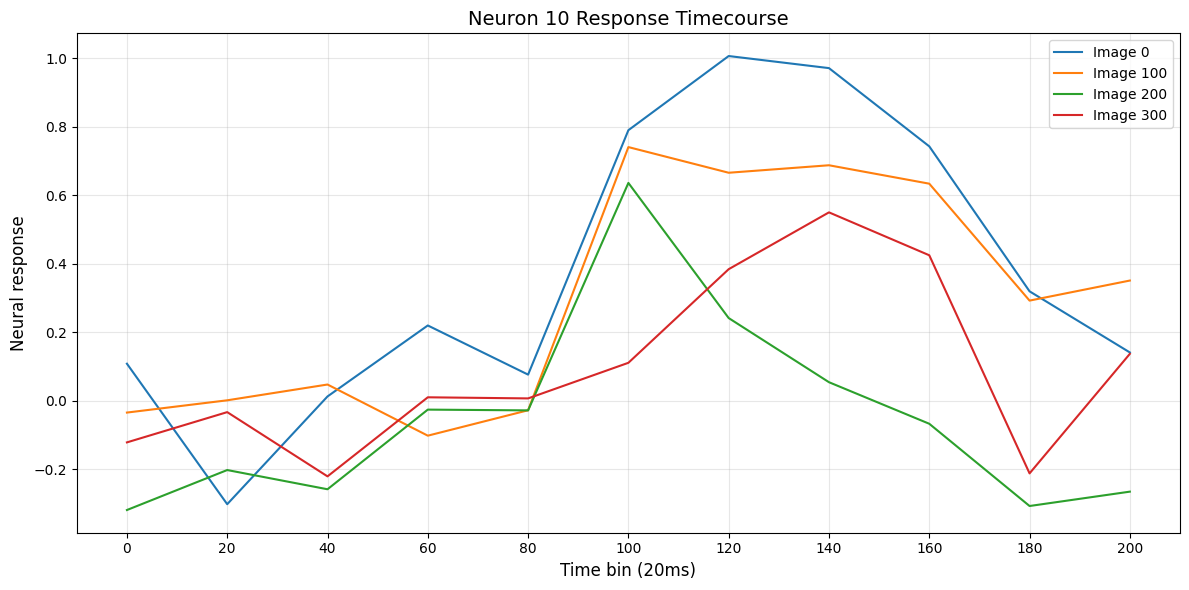

In [ ]:
# Let's check out the time-binned trial-averaged data, which shows how neurons respond over time
time_binned_data = Ventral_Dataset['time_binned_trial_averaged']
print("Shape of time_binned_trial_averaged:", time_binned_data.shape)
# This gives us responses for each image, time bin, and neuron

# Let's look at a single neuron's response to a few different images over time
neuron_index = 10
example_image_indices = [0, 100, 200, 300]

plt.figure(figsize=(12, 6))
for img_idx in example_image_indices:
    # Extract time course for this neuron/image
    neuron_response = time_binned_data[img_idx, :, neuron_index]
    plt.plot(neuron_response, label=f'Image {img_idx}')

plt.xlabel('Time bin (20ms)', fontsize=12)
plt.xticks(np.arange(11), np.arange(11) * 20)
plt.ylabel('Neural response', fontsize=12)
plt.title(f'Neuron {neuron_index} Response Timecourse', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Exploring Neural activity to different categories:

In [ ]:
def compute_category_averages(neural_data, categories):
    """
    Compute the average neural response for each category.

    Parameters:
    neural_data: Array of shape (n_images, n_neurons) containing neural responses
    categories: Array of shape (n_images,) containing category labels for each image

    Returns:
    Dictionary mapping category names to average responses
    """
    neural_data_tensor = torch.tensor(neural_data, dtype=torch.float32)
    category_averages = {}
    for category in np.unique(categories):
        # Find images of this category
        category_mask = categories == category

        # Get neural responses for those images
        category_responses = neural_data_tensor[category_mask]

        # Compute average response (hint: use torch.mean along the appropriate dimension)
        average_response = torch.mean(category_responses, dim=0)

        # Store in dictionary
        category_averages[category] = average_response

    return category_averages

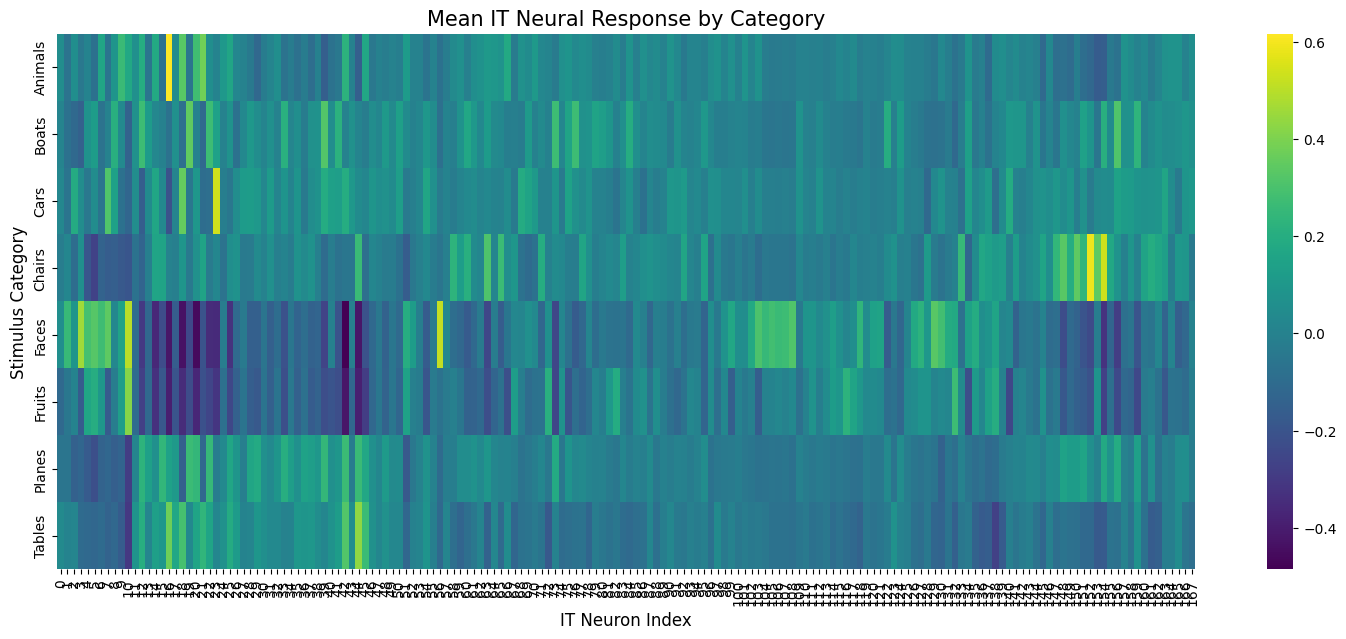

In [ ]:
# Now let's visualize

# computing category averages
IT_category_averages = compute_category_averages(IT_Neural_Data, categories)

# Create tensors containing all category averages for easier plotting
IT_category_means = torch.stack([IT_category_averages[cat] for cat in unique_categories])

# Plot heatmaps
plt.figure(figsize=(15, 12))

# IT heatmap
plt.subplot(2, 1, 2)
sns.heatmap(
    IT_category_means.numpy(),
    cmap="viridis",
    xticklabels=range(0, len(IT_NEURONS)),
    yticklabels=[c.decode('utf-8') if isinstance(c, bytes) else c for c in unique_categories],
)
plt.title("Mean IT Neural Response by Category", fontsize=15)
plt.xlabel("IT Neuron Index", fontsize=12)
plt.ylabel("Stimulus Category", fontsize=12)

plt.tight_layout()
plt.show()

### Project to 2 dimensions:

In [ ]:
def plot_in_2d_projection(vl, cat1, cat2):
    cat1 = ensure_bytes(cat1)
    cat2 = ensure_bytes(cat2)
    vl = ensure_bytes(vl)
    # Get the subset of data for the two categories
    subset_inds = (var_level == vl) & ((categories == cat1) | (categories == cat2))
    Neural_Data_subset = IT_Neural_Data[subset_inds]
    category_subset = categories[subset_inds]

    # Using the unsupervised "Multi-dimensional scaling" method (MDS)
    distmat = 1 - np.corrcoef(Neural_Data_subset)
    x, y = MDS(dissimilarity="precomputed").fit_transform(distmat).T

    xb = x[category_subset == cat1]
    yb = y[category_subset == cat1]
    xc = x[category_subset == cat2]
    yc = y[category_subset == cat2]
    plt.scatter(xb, yb, color="b")
    plt.scatter(xc, yc, color="r")
    plt.axis("equal")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

Text(0.5, 1.0, 'Animals (blue) vs Fruits (red) var level V6')

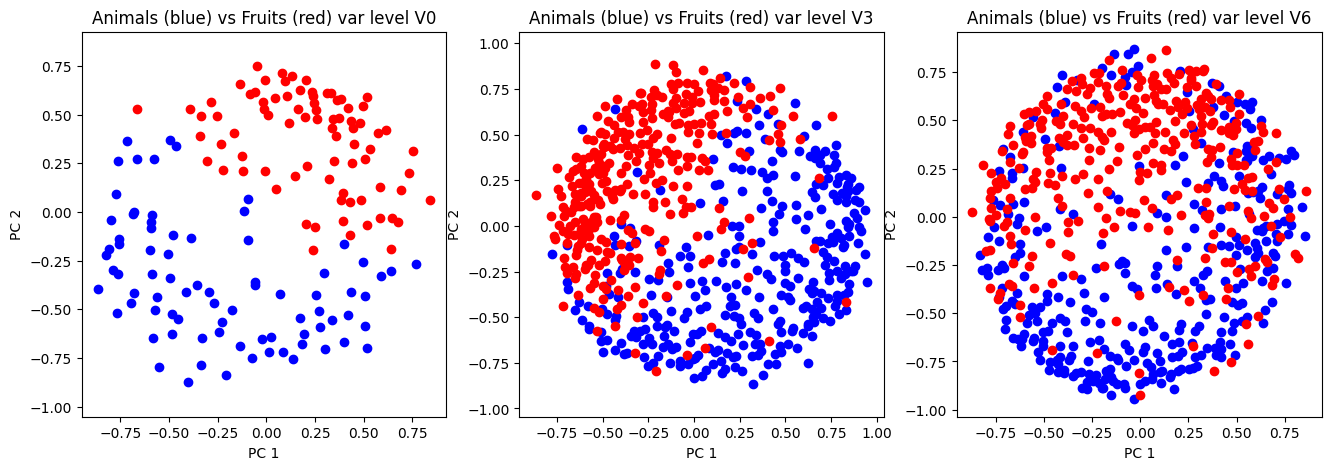

In [ ]:
cat1 = "Animals"
cat2 = "Fruits"

fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plot_in_2d_projection("V0", cat1, cat2)
plt.title("%s (blue) vs %s (red) var level %s" % (cat1, cat2, "V0"))

plt.subplot(1, 3, 2)
plot_in_2d_projection("V3", cat1, cat2)
plt.title("%s (blue) vs %s (red) var level %s" % (cat1, cat2, "V3"))

plt.subplot(1, 3, 3)
plot_in_2d_projection("V6", cat1, cat2)
plt.title("%s (blue) vs %s (red) var level %s" % (cat1, cat2, "V6"))

Text(0.5, 1.0, 'Cars (blue) vs Faces (red) var level V6')

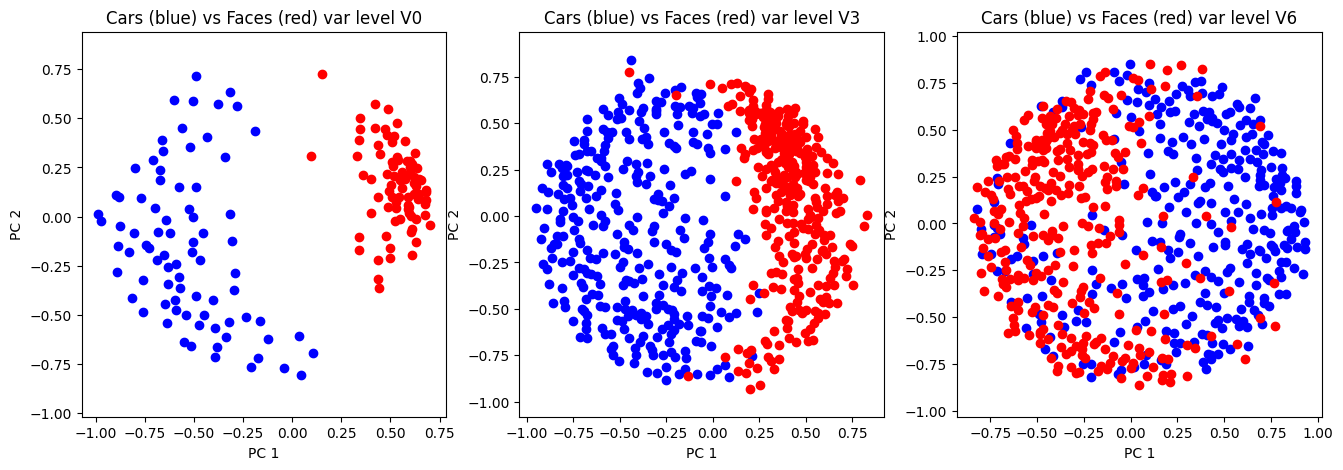

In [ ]:
cat1 = "Cars"
cat2 = "Faces"

fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plot_in_2d_projection("V0", cat1, cat2)
plt.title("%s (blue) vs %s (red) var level %s" % (cat1, cat2, "V0"))

plt.subplot(1, 3, 2)
plot_in_2d_projection("V3", cat1, cat2)
plt.title("%s (blue) vs %s (red) var level %s" % (cat1, cat2, "V3"))

plt.subplot(1, 3, 3)
plot_in_2d_projection("V6", cat1, cat2)
plt.title("%s (blue) vs %s (red) var level %s" % (cat1, cat2, "V6"))

Text(0.5, 1.0, 'Cars (blue) vs Fruits (red) var level V6')

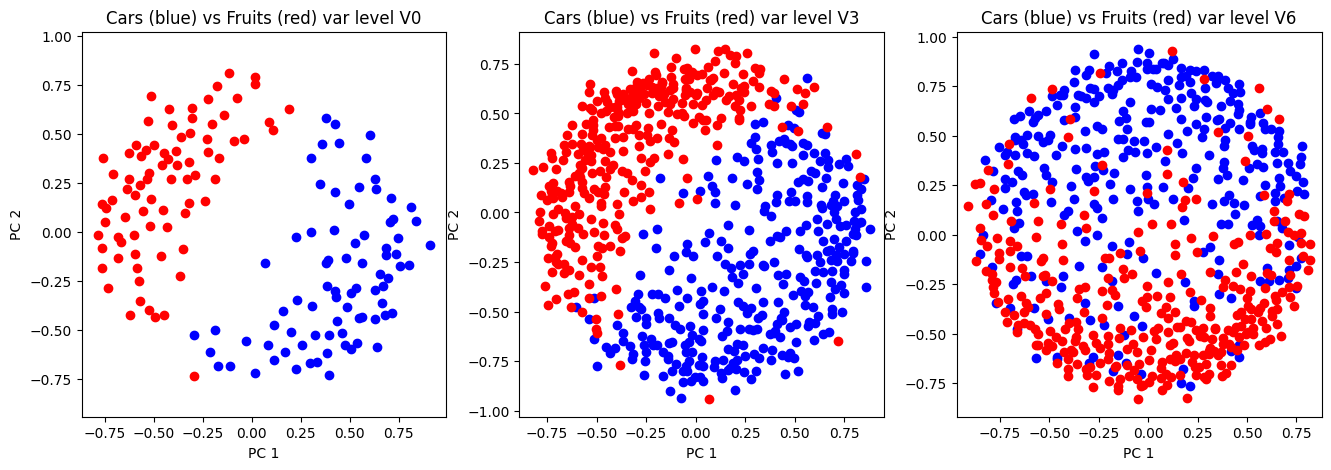

In [ ]:
Scat1 = "Faces"
cat2 = "Fruits"

fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plot_in_2d_projection("V0", cat1, cat2)
plt.title("%s (blue) vs %s (red) var level %s" % (cat1, cat2, "V0"))

plt.subplot(1, 3, 2)
plot_in_2d_projection("V3", cat1, cat2)
plt.title("%s (blue) vs %s (red) var level %s" % (cat1, cat2, "V3"))

plt.subplot(1, 3, 3)
plot_in_2d_projection("V6", cat1, cat2)
plt.title("%s (blue) vs %s (red) var level %s" % (cat1, cat2, "V6"))

We can see that at low variation (V0), the categories form distinct clusters in neural space, meaning the brain represents them as clearly separate object categories. As variation increases (V6), these clusters start to overlap, making category discrimination more challenging.

Let's now see if we can build classifiers to distinguish between these categories, and how their performance changes with variation.


## Introduction to PyTorch Neural Network Modules

Before we implement our classifiers, let's review how to build models in PyTorch. PyTorch provides an elegant way to define neural networks using the `nn.Module` class and pre-built layers like `nn.Linear`.

A linear layer in PyTorch is defined as:

```python
nn.Linear(in_features, out_features)
```

This creates a module that performs: `y = xW^T + b`, where:

- `x` is the input tensor of shape `(batch_size, in_features)`
- `W` is a learnable weight matrix of shape `(out_features, in_features)`
- `b` is a learnable bias vector of shape `(out_features)`

For classification, we'll use linear layers to map from our input features (neural activity) to either:

- A single score for binary classification (SVM)
- Multiple scores or probabilities for multi-class classification


## Exercise 1: Binary Classification with SVM

We'll start with a binary classification problem: distinguishing between two categories of objects based on neural activity patterns.

Support Vector Machines (SVMs) aim to find a hyperplane that maximizes the margin between classes. For binary classification, SVMs output a single score where:

- Positive scores indicate one class
- Negative scores indicate the other class

The key component of SVMs is the hinge loss function: `max(0, 1 - y * f(x))` where:

- `y` is the label (-1 or 1)
- `f(x)` is the model's output score


In [ ]:
# First, let's prepare our data for binary classification
def prepare_binary_data(category1, category2, vl):
    """
    Prepare data for binary classification between two categories.

    Args:
        category1: First category
        category2: Second category
        vl: Variation level

    Returns:
        features_tensor: PyTorch tensor of neural data
        labels_tensor: PyTorch tensor of binary labels (1 for category1, -1 for category2)
    """
    # Ensure inputs are bytes for HDF5 compatibility
    category1 = ensure_bytes(category1)
    category2 = ensure_bytes(category2)
    vl = ensure_bytes(vl)

    # Get indices for the two categories at the specified variation level
    mask = (var_level == vl) & ((categories == category1) | (categories == category2))

    # Extract features and labels
    features = IT_Neural_Data[mask]

    # Create binary labels: 1 for category1, -1 for category2
    labels = np.ones(np.sum(mask))
    labels[categories[mask] == category2] = -1

    # Convert to PyTorch tensors
    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    return features_tensor, labels_tensor


# Choose two categories for binary classification
cat1 = unique_categories[0]  # e.g., 'Animals'
cat2 = unique_categories[1]  # e.g., 'Cars'
variation_level = "V3"  # Medium variation

features_tensor, labels_tensor = prepare_binary_data(cat1, cat2, variation_level)
print(
    f"Binary classification data: {features_tensor.shape[0]} samples, {features_tensor.shape[1]} features"
)
print(
    f"Class balance: {torch.sum(labels_tensor == 1).item()} vs {torch.sum(labels_tensor == -1).item()}"
)

Binary classification data: 640 samples, 168 features
Class balance: 320 vs 320


### Exercise 1.1: Implement Binary SVM Model

Now, let's implement a binary SVM using PyTorch's `nn.Module` and `nn.Linear`. The model should output a single score for each input.


In [ ]:
# Exercise 1.1: Implement Binary SVM with Linear Layer
class BinaryLinearSVM(nn.Module):
    """
    Binary linear SVM classifier.
    """

    def __init__(self, input_dim):
        """
        Initialize the SVM model.

        Args:
            input_dim: Dimensionality of input features
        """
        super(BinaryLinearSVM, self).__init__()

        # YOUR CODE HERE
        # Initialize a linear layer (weights and bias) with nn.Linear

    def forward(self, x):
        """
        Forward pass to compute SVM scores.

        Args:
            x: Input features of shape (batch_size, input_dim)

        Returns:
            SVM scores of shape (batch_size,)
        """
        # YOUR CODE HERE
        # Compute and return the raw scores
        # use .squeeze(1) after applying the linear layer to remove extra dimension
        pass

    def predict(self, x):
        """
        Predict class labels.

        Args:
            x: features of shape (batch_size, input_dim)

        Returns:
            Predicted class labels (-1 or 1) of shape (batch_size,)
        """
        pass
        # apply forward, then...
        # HINT: use torch.where to convert all scores <= 0 to torch.tensor(-1.0), and otherwise to torch.tensor(1.0)
        # see documentation for torch.where: https://pytorch.org/docs/stable/generated/torch.where.html

In [ ]:
# Solution 1.1: Binary SVM Implementation
class BinaryLinearSVM(nn.Module):
    """
    Binary linear SVM classifier.
    """

    def __init__(self, input_dim):
        """
        Initialize the SVM model.

        Args:
            input_dim: Dimensionality of input features
        """
        super(BinaryLinearSVM, self).__init__()

        # Initialize a linear layer (weights and bias) with nn.Linear
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        """
        Forward pass to compute SVM scores.

        Args:
            x: Input features of shape (batch_size, input_dim)

        Returns:
            SVM scores of shape (batch_size,)
        """
        # Compute and return the raw scores
        # use .squeeze(1) after applying the linear layer to remove extra dimension
        return self.linear(x).squeeze(1)

    def predict(self, x):
        """
        Predict class labels.

        Args:
            x: features of shape (batch_size, input_dim)

        Returns:
            Predicted class labels (-1 or 1) of shape (batch_size,)
        """
        pass
        # apply forward, then...
        # HINT: use torch.where to convert all scores <= 0 to torch.tensor(-1.0), and otherwise to torch.tensor(1.0)
        # see documentation for torch.where: https://pytorch.org/docs/stable/generated/torch.where.html
        return torch.where(self.forward(x) <= 0, torch.tensor(-1.0), torch.tensor(1.0))

In [ ]:
model = BinaryLinearSVM(10)
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0644, -0.1944,  0.2990, -0.2789, -0.2312,  0.0418, -0.0614,  0.1162,
          -0.3000,  0.3121]], requires_grad=True),
 Parameter containing:
 tensor([-0.1258], requires_grad=True)]

### Exercise 1.2: Implement Hinge Loss

Now we need to implement the hinge loss function for SVM training:

$$L(y, \hat{y}) = \max(0, 1 - y \cdot \hat{y})$$

where $y$ is the true label (-1 or 1) and $\hat{y}$ is the predicted score.


In [ ]:
# Exercise 1.2: Implement Hinge Loss for SVM
class HingeLoss(nn.Module):
    """
    Hinge loss for binary SVM.
    """

    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, predictions, targets):
        """
        Compute hinge loss.

        Args:
            predictions: Raw SVM scores
            targets: True labels (-1 or 1)

        Returns:
            Mean hinge loss
        """
        # YOUR CODE HERE
        # Apply max(0, 1 - y * f(x)) at each position and take the mean of the result
        # HINT: rather than using torch.max (which gives maximum value across entire matrix)...
        # use torch.clamp to set the minimum of values to be 0 - look up documentation here: https://pytorch.org/docs/stable/generated/torch.clamp.html
        pass

In [ ]:
# Solution 1.2: Hinge Loss Implementation
class HingeLoss(nn.Module):
    """
    Hinge loss for binary SVM.
    """

    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, predictions, targets):
        """
        Compute hinge loss.

        Args:
            predictions: Raw SVM scores
            targets: True labels (-1 or 1)

        Returns:
            Mean hinge loss
        """
        # Calculate margin term: 1 - y * f(x)
        margins = 1 - predictions * targets

        # Apply max(0, margin) for each sample
        losses = torch.clamp(margins, min=0)

        # Return mean loss
        return losses.mean()

### Exercise 1.3: Train Binary SVM

Now let's train our SVM using the UniversalProcedure class and evaluate its performance with cross-validation.


In [ ]:
# Exercise 1.3: Train Binary SVM

# get binary data
variation_level = "V3"
features_tensor, labels_tensor = prepare_binary_data(cat1, cat2, variation_level)

# YOUR CODE HERE
# 1. Initialize the SVM model with input_dim (HINT: get those from the shape of the features_tensor)
# 2. Create a cross-validator instance
# 3. Create a UniversalProcedure instance with the HingeLoss as the loss_func
# 4. Train and evaluate the model using the evaluate method - use train_epochs=200, lr=0.001

# Print results - uncomment below
# print(f"SVM performance for {cat1.decode() if isinstance(cat1, bytes) else cat1} vs "
#       f"{cat2.decode() if isinstance(cat2, bytes) else cat2} at variation level {variation_level}:")
# for metric, value in svm_results.items():
#     if 'CV' in metric and 'Std' not in metric:
#         print(f"{metric}: {value:.4f}")

In [ ]:
# Solution 1.3: Train Binary SVM
# Initialize the SVM model
input_dim = features_tensor.shape[1]
svm_model = BinaryLinearSVM(input_dim)

# Create cross-validation splitter
cv_splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Create UniversalProcedure with hinge loss
hinge_loss = HingeLoss()
procedure = UniversalProcedure(cross_validator=cv_splitter, loss_func=hinge_loss)

# Train and evaluate
svm_results, svm_state_dicts = procedure.evaluate(
    model=svm_model, x=features_tensor, y=labels_tensor, train_epochs=200, lr=0.001
)

# Print results
print(
    f"SVM performance for {cat1.decode() if isinstance(cat1, bytes) else cat1} vs "
    f"{cat2.decode() if isinstance(cat2, bytes) else cat2} at variation level {variation_level}:"
)
for metric, value in svm_results.items():
    if "CV" in metric and "Std" not in metric:
        print(f"{metric}: {value:.4f}")

0it [00:00, ?it/s]
 63%|██████▎   | 126/200 [00:00<00:00, 1257.60it/s]
1it [00:00,  5.52it/s]
 64%|██████▍   | 128/200 [00:00<00:00, 1272.96it/s]
2it [00:00,  5.59it/s]
 64%|██████▍   | 129/200 [00:00<00:00, 1284.07it/s]
3it [00:00,  5.54it/s]
 66%|██████▌   | 131/200 [00:00<00:00, 1309.85it/s]
4it [00:00,  5.72it/s]
 64%|██████▎   | 127/200 [00:00<00:00, 1265.94it/s]
5it [00:00,  5.67it/s]

SVM performance for Animals vs Boats at variation level V3:
CV Accuracy: 0.9422


### Visualize Decision Boundary

To better understand our SVM classifier, let's visualize the decision boundary in 2D space.


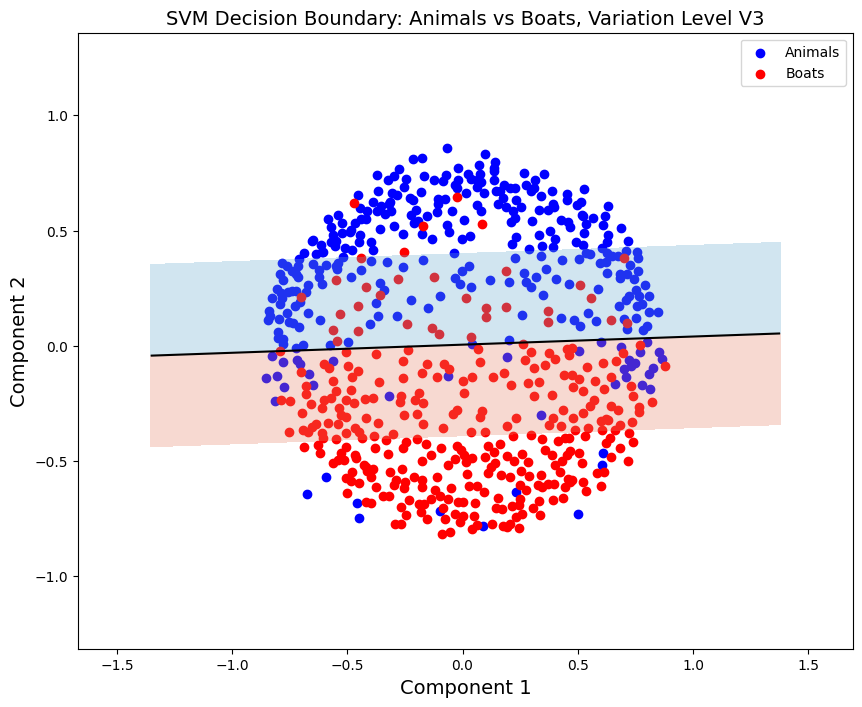

In [ ]:
def plot_svm_decision_boundary(vl, cat1, cat2):
    """Plot data points and SVM decision boundary in 2D projection."""
    cat1 = ensure_bytes(cat1)
    cat2 = ensure_bytes(cat2)
    vl = ensure_bytes(vl)

    # Get the subset of data for the two categories
    subset_inds = (var_level == vl) & ((categories == cat1) | (categories == cat2))
    Neural_Data_subset = IT_Neural_Data[subset_inds]
    category_subset = categories[subset_inds]

    # Project to 2D using MDS
    distmat = 1 - np.corrcoef(Neural_Data_subset)
    coords = MDS(dissimilarity="precomputed", random_state=42).fit_transform(distmat)
    x, y = coords.T

    # Plot data points
    plt.figure(figsize=(10, 8))
    cat1_label = cat1.decode() if isinstance(cat1, bytes) else cat1
    cat2_label = cat2.decode() if isinstance(cat2, bytes) else cat2
    plt.scatter(
        x[category_subset == cat1],
        y[category_subset == cat1],
        color="b",
        label=cat1_label,
    )
    plt.scatter(
        x[category_subset == cat2],
        y[category_subset == cat2],
        color="r",
        label=cat2_label,
    )

    # Create binary labels (1 for cat1, -1 for cat2)
    binary_labels = torch.ones(len(category_subset))
    binary_labels[category_subset == cat2] = -1

    # Create and train a 2D SVM model
    model_2d = BinaryLinearSVM(2)
    data_2d = torch.tensor(coords, dtype=torch.float32)

    # Train with hinge loss
    optimizer = optim.Adam(model_2d.parameters(), lr=0.01)
    loss_fn = HingeLoss()

    for _ in range(300):
        predictions = model_2d(data_2d)
        loss = loss_fn(predictions, binary_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Create a mesh grid for decision boundary visualization
    x_min, x_max = x.min() - 0.5, x.max() + 0.5
    y_min, y_max = y.min() - 0.5, y.max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Predict on the grid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    with torch.no_grad():
        Z = model_2d(torch.tensor(grid_points, dtype=torch.float32)).numpy()
        Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contour(xx, yy, Z, levels=[0], colors="k", linestyles="-")
    plt.contourf(xx, yy, Z, levels=[-1, 0, 1], cmap=plt.cm.RdBu, alpha=0.3)

    plt.xlabel("Component 1", fontsize=14)
    plt.ylabel("Component 2", fontsize=14)
    plt.title(
        f"SVM Decision Boundary: {cat1_label} vs {cat2_label}, Variation Level {vl.decode() if isinstance(vl, bytes) else vl}",
        fontsize=14,
    )
    plt.legend()
    plt.axis("equal")
    plt.show()


variation_level = "V3"
plot_svm_decision_boundary(variation_level, cat1, cat2)

## Exercise 2: Multi-Class Classification with SVM

Now let's extend our approach to multi-class classification. There are several strategies for multi-class SVMs, but we'll use the one-vs-all approach, where we train one SVM for each class against all others.


In [ ]:
# Prepare data for multi-class classification
def prepare_multiclass_data(vl):
    """
    Prepare data for multi-class classification.

    Args:
        vl: Variation level

    Returns:
        features_tensor: PyTorch tensor of neural data
        labels_tensor: PyTorch tensor of integer labels
        label_map: Dictionary mapping category names to integer indices
    """
    vl = ensure_bytes(vl)

    # Get indices for the specified variation level
    mask = var_level == vl

    # Extract features
    features = IT_Neural_Data[mask]
    category_subset = categories[mask]

    # Create integer labels and label mapping
    label_map = {cat: i for i, cat in enumerate(unique_categories)}
    labels = np.array([label_map[cat] for cat in category_subset])

    # Convert to PyTorch tensors
    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)  # Use long for class indices

    return features_tensor, labels_tensor, label_map


# Prepare multi-class data at moderate variation
vl = "V3"
features_tensor, labels_tensor, label_map = prepare_multiclass_data(vl)
print(
    f"Multi-class data: {features_tensor.shape[0]} samples, {features_tensor.shape[1]} features"
)
print(f"Number of classes: {len(unique_categories)}")

# Check class distribution
for cat, idx in label_map.items():
    cat_name = cat.decode() if isinstance(cat, bytes) else cat
    count = torch.sum(labels_tensor == idx).item()
    print(f"Class {idx} ({cat_name}): {count} samples")

Multi-class data: 2560 samples, 168 features
Number of classes: 8
Class 0 (Animals): 320 samples
Class 1 (Boats): 320 samples
Class 2 (Cars): 320 samples
Class 3 (Chairs): 320 samples
Class 4 (Faces): 320 samples
Class 5 (Fruits): 320 samples
Class 6 (Planes): 320 samples
Class 7 (Tables): 320 samples


### Exercise 2.1: Implement Multi-Class SVM

Now, let's implement a multi-class SVM using the one-vs-all approach. We'll use a single linear layer that outputs a score for each class.


In [ ]:
# Exercise 2.1: Implement Multi-Class SVM
class MultiClassSVM(nn.Module):
    """
    Multi-class SVM using one-vs-all approach.
    """

    def __init__(self, input_dim, num_classes):
        """
        Initialize the multi-class SVM model.

        Args:
            input_dim: Dimensionality of input features
            num_classes: Number of classes to classify
        """
        super(MultiClassSVM, self).__init__()

        # YOUR CODE HERE
        # Define the model parameters using nn.Linear

    def forward(self, x):
        """
        Forward pass to compute scores for each class.

        Args:
            x: Input features of shape (batch_size, input_dim)

        Returns:
            Class scores of shape (batch_size, num_classes)
        """
        # YOUR CODE HERE
        # Compute and return scores for each class
        # HINT: this should be implemented the same as the binary class, but this time no need to squeeze!
        pass

    def predict(self, x):
        """
        Predict class labels.

        Args:
            x: Input features of shape (batch_size, input_dim)

        Returns:
            Predicted class labels of shape (batch_size,)
        """
        # YOUR CODE HERE (HINT:  apply forward, then use torch.argmax: https://pytorch.org/docs/stable/generated/torch.argmax.html)
        pass

In [ ]:
# Solution 2.1: Multi-Class SVM
class MultiClassSVM(nn.Module):
    """
    Multi-class SVM using one-vs-all approach.
    """

    def __init__(self, input_dim, num_classes):
        """
        Initialize the multi-class SVM model.

        Args:
            input_dim: Dimensionality of input features
            num_classes: Number of classes to classify
        """
        super(MultiClassSVM, self).__init__()

        # Define the model parameters using nn.Linear
        # This creates a linear layer that outputs a score for each class
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        """
        Forward pass to compute scores for each class.

        Args:
            x: Input features of shape (batch_size, input_dim)

        Returns:
            Class scores of shape (batch_size, num_classes)
        """
        # Compute and return scores for each class
        return self.linear(x)

    def predict(self, x):
        """
        Predict class labels.

        Args:
            x: Input features of shape (batch_size, input_dim)

        Returns:
            Predicted class labels of shape (batch_size,)
        """
        # YOUR CODE HERE (HINT:  apply forward, then use torch.argmax: https://pytorch.org/docs/stable/generated/torch.argmax.html)
        return torch.argmax(self.forward(x), dim=1)

### Multi-Class Hinge Loss

For multi-class SVMs, we need a modified hinge loss that considers scores for all classes. The goal is to make the score for the correct class higher than scores for all other classes by at least a margin of 1. Let's review how this is implemented below:


In [ ]:
class MultiClassHingeLoss(nn.Module):
    """
    Multi-class hinge loss for SVM.
    """

    def __init__(self):
        super(MultiClassHingeLoss, self).__init__()

    def forward(self, predictions, targets):
        """
        Compute multi-class hinge loss.

        Args:
            predictions: Class scores of shape (batch_size, num_classes)
            targets: Class indices of shape (batch_size,)

        Returns:
            Mean multi-class hinge loss
        """
        batch_size = targets.size(0)

        # Get the score for the correct class for each sample
        correct_class_scores = predictions[torch.arange(batch_size), targets]

        # Calculate margins: score_j - score_yi + 1
        # We add 1 to make sure correct class score is higher by at least 1
        margins = predictions - correct_class_scores.unsqueeze(1) + 1.0

        # Don't include the margin for the correct class (should be 1)
        margins[torch.arange(batch_size), targets] = 0

        # Clamp at 0 (hinge) and sum over classes
        loss = torch.clamp(margins, min=0).sum(dim=1) / (predictions.size(1) - 1)

        # Return mean loss over the batch
        return loss.mean()

### Exercise 2.3: Train Multi-Class SVM

Now let's train our multi-class SVM using the Universal Procedure class.


In [ ]:
# Exercise 2.3: Train Multi-Class SVM

# Prepare multi-class data at moderate variation
vl = "V3"
features_tensor, labels_tensor, label_map = prepare_multiclass_data(vl)

# YOUR CODE HERE
# 1. Initialize the multi-class SVM model - HINT: get input_dim from the shape of the features_tensor, and use len(unique_categories) to get num_classes
# 2. Create a UniversalProcedure instance with the multi-class hinge loss
# 3. Train and evaluate the model - use train_epochs = 200, lr=0.01

# Print the cross-validation accuracy - uncomment below

In [ ]:
# Solution 2.3: Train Multi-Class SVM

# Prepare multi-class data at moderate variation
vl = "V3"
features_tensor, labels_tensor, label_map = prepare_multiclass_data(vl)

# Initialize the model
input_dim = features_tensor.shape[1]
num_classes = len(unique_categories)
svm_model = MultiClassSVM(input_dim, num_classes)

# Create UniversalProcedure with multi-class hinge loss
mc_hinge_loss = MultiClassHingeLoss()
procedure = UniversalProcedure(
    cross_validator=cv_splitter,
    loss_func=mc_hinge_loss,
)

# Train and evaluate
svm_results, svm_state_dicts = procedure.evaluate(
    model=svm_model, x=features_tensor, y=labels_tensor, train_epochs=200, lr=0.01
)

# Print results
print(f"Multi-class SVM performance at variation level {vl}:")
for metric, value in svm_results.items():
    if "CV" in metric and "Std" not in metric:
        print(f"{metric}: {value:.4f}")

0it [00:00, ?it/s]
 80%|████████  | 161/200 [00:00<00:00, 387.37it/s]
1it [00:00,  1.93it/s]
 90%|████████▉ | 179/200 [00:00<00:00, 341.09it/s]
2it [00:01,  1.79it/s]
 84%|████████▎ | 167/200 [00:00<00:00, 408.67it/s]
3it [00:01,  1.86it/s]
 93%|█████████▎| 186/200 [00:00<00:00, 349.66it/s]
4it [00:02,  1.81it/s]
 84%|████████▎ | 167/200 [00:00<00:00, 391.23it/s]
5it [00:02,  1.84it/s]

Multi-class SVM performance at variation level V3:
CV Accuracy: 0.8324


## Exercise 3: Logistic Regression

Now we'll implement logistic regression with softmax, which provides a probabilistic approach to classification. Unlike SVM which focuses on maximizing margins, logistic regression models the probability distribution over classes.

The key differences between SVM and logistic regression are:

1. **Output Interpretation**:
   - SVM: Raw scores that determine class boundaries
   - Logistic Regression: Probabilities that sum to 1 (via softmax)
2. **Loss Function**:
   - SVM: Hinge loss that cares about margin violations
   - Logistic Regression: Cross-entropy loss that maximizes the likelihood of correct classes
3. **Decision Boundary**:
   - SVM: Maximizes the margin between closest examples
   - Logistic Regression: Places boundary where posterior probabilities equal 0.5


In [ ]:
# Exercise 3.1: Implement the Softmax function
def softmax(x):
    """
    Compute softmax values for each set of scores in x.

    Args:
        x: Input tensor of shape (batch_size, num_classes)

    Returns:
        Softmax probabilities of shape (batch_size, num_classes)
    """
    # YOUR CODE HERE
    # compute exp(x) / sum of exp(x) over the 1st dimension
    # use keepdim=True in the torch.sum function
    pass

In [ ]:
# Solution 3.1: Softmax implementation
def softmax(x):
    """
    Compute softmax values for each set of scores in x.

    Args:
        x: Input tensor of shape (batch_size, num_classes)

    Returns:
        Softmax probabilities of shape (batch_size, num_classes)
    """
    # Normalize
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1, keepdim=True)


# Note: In practice, you can also use torch.nn.functional.softmax(x, dim=1)

In [ ]:
# Exercise 3.2: Implement Logistic Regression with Softmax
class LogisticRegression(nn.Module):
    """
    Multi-class logistic regression model with softmax.
    """

    def __init__(self, input_dim, num_classes):
        """
        Initialize the logistic regression model.

        Args:
            input_dim: Dimensionality of input features
            num_classes: Number of classes to classify
        """
        super(LogisticRegression, self).__init__()

        # YOUR CODE HERE
        # Define the model parameters using nn.Linear
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        """
        Forward pass to compute class probabilities.

        Args:
            x: Input features of shape (batch_size, input_dim)

        Returns:
            Class probabilities of shape (batch_size, num_classes)
        """
        # YOUR CODE HERE
        # Apply linear transformation and then softmax
        pass

    def predict(self, x):
        """
        Predict class labels.

        Args:
            x: Input features of shape (batch_size, input_dim)

        Returns:
            Predicted class labels of shape (batch_size,)
        """
        # YOUR CODE HERE
        pass

In [ ]:
# Solution 3.2: Logistic Regression with Softmax
class LogisticRegression(nn.Module):
    """
    Multi-class logistic regression model with softmax.
    """

    def __init__(self, input_dim, num_classes):
        """
        Initialize the logistic regression model.

        Args:
            input_dim: Dimensionality of input features
            num_classes: Number of classes to classify
        """
        super(LogisticRegression, self).__init__()

        # Define the model parameters using nn.Linear
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        """
        Forward pass to compute class probabilities.

        Args:
            x: Input features of shape (batch_size, input_dim)

        Returns:
            Class probabilities of shape (batch_size, num_classes)
        """
        # Apply linear transformation and then softmax
        logits = self.linear(x)
        return softmax(logits)

    def predict(self, x):
        """
        Predict class labels.

        Args:
            x: Input features of shape (batch_size, input_dim)

        Returns:
            Predicted class labels of shape (batch_size,)
        """
        # YOUR CODE HERE
        return torch.argmax(self.forward(x), dim=1)

### Exercise 3.3: Train a Multi-Class Logistic Regression Model


#### Note: Cross-Entropy Loss for Logistic Regression

For logistic regression, we use cross-entropy loss, which measures the difference between two probability distributions: the predicted probabilities and the true distribution (one-hot encoded target).

The cross-entropy loss is defined as:

$$L(y, \hat{y}) = -\sum_{i=1}^{n} y_i \log(p(\hat{y})_i)$$

where:

- $y_i$ is the true probability of class $i$ (typically 0 or 1 for one-hot encoding)
- $\hat{y}_i$ is the predicted probability of class $i$

For multi-class classification with one-hot encoded targets (meaning the true class probability becomes 1), if $c$ is the correct class index, this simplifies to:

$$L(y, \hat{y}) = -\log(\hat{y}_c)$$

PyTorch provides the cross-entropy loss as a built-in function: `torch.nn.CrossEntropyLoss()`. This function combines softmax and negative log-likelihood loss in a single, more numerically stable operation.

This means we don't even need to apply softmax in our logistic regression function since it is applied inside the loss function. That is, it's enough to return what is called the logits, or unnormalized log probabilities (this are the scores you got after applying the linear layer and before you applied softmax in the forward function). However, if you want output probabilities, you would still need to apply softmax.


The torch loss function that takes in log probabilities directly - meaning it does not apply softmax automatically, is called `torch.nn.NLLLoss()`, and that is what we will use since you already got the probabilities via softmax.


In [ ]:
nll_loss = lambda probs, target: nn.NLLLoss()(torch.log(probs), target)

# YOUR CODE HERE
# 1. Use the same prepared multi-class data from the SVM case
# 2. Initialize the LogisticRegression model
# 3. Create a UniversalProcedure instance with nll_loss as its loss function
# 4. Train and evaluate the model

# Print results - uncomment below
# print(f"Logistic Regression performance at variation level {vl}:")
# for metric, value in logistic_results.items():
#     if 'CV' in metric and 'Std' not in metric:
#         print(f"{metric}: {value:.4f}")

# # Compare results between SVM and Logistic Regression
# print("\nComparison between SVM and Logistic Regression:")
# print(f"SVM Accuracy: {svm_results['CV Accuracy']:.4f}")
# print(f"Logistic Regression Accuracy: {logistic_results['CV Accuracy']:.4f}")

In [ ]:
nll_loss = lambda probs, target: nn.NLLLoss()(torch.log(probs), target)

# Solution 3.4: Train a Multi-Class Logistic Regression Model
# Initialize the logistic regression model
logistic_model = LogisticRegression(input_dim, num_classes)

# Create a UniversalProcedure instance with nll_loss as its loss function

procedure = UniversalProcedure(
    cross_validator=cv_splitter,
    loss_func=nll_loss,
)

# Train and evaluate
logistic_results, logistic_state_dicts = procedure.evaluate(
    model=logistic_model, x=features_tensor, y=labels_tensor, train_epochs=200, lr=0.01
)

# Print results
print(f"Logistic Regression performance at variation level {vl}:")
for metric, value in logistic_results.items():
    if "CV" in metric and "Std" not in metric:
        print(f"{metric}: {value:.4f}")

# Compare results between SVM and Logistic Regression
print("\nComparison between SVM and Logistic Regression:")
print(f"SVM Accuracy: {svm_results['CV Accuracy']:.4f}")
print(f"Logistic Regression Accuracy: {logistic_results['CV Accuracy']:.4f}")

0it [00:00, ?it/s]
 90%|█████████ | 181/200 [00:00<00:00, 606.66it/s]
1it [00:00,  2.80it/s]
 90%|█████████ | 181/200 [00:00<00:00, 609.15it/s]
2it [00:00,  2.84it/s]
 68%|██████▊   | 136/200 [00:00<00:00, 647.05it/s]
3it [00:01,  2.96it/s]
 99%|█████████▉| 198/200 [00:00<00:00, 649.12it/s]
4it [00:01,  2.99it/s]
100%|█████████▉| 199/200 [00:00<00:00, 606.31it/s]
5it [00:01,  2.95it/s]

Logistic Regression performance at variation level V3:
CV Accuracy: 0.8344

Comparison between SVM and Logistic Regression:
SVM Accuracy: 0.8324
Logistic Regression Accuracy: 0.8344


### Classifier Performance Across Variation Levels

Now let's evaluate how our classifiers perform across different variation levels. We expect that as variation increases, classification performance will decrease, since the neural representations become more variable.


In [ ]:
def train_and_evaluate_across_variations(model_class, loss_func):
    """
    Train and evaluate a model across different variation levels.

    Args:
        model_class: The classifier class (MultiClassSVM or LogisticRegression)
        loss_func: The loss function to use

    Returns:
        Dictionary mapping variation levels to accuracy scores
    """
    results = {}

    # Get all variation levels
    variation_levels = np.unique(var_level)

    # Train and evaluate for each variation level
    for vl in variation_levels:
        # Prepare data for this variation level
        features_tensor, labels_tensor, label_map = prepare_multiclass_data(vl)

        # Initialize the model
        input_dim = features_tensor.shape[1]
        num_classes = len(unique_categories)
        model = model_class(input_dim, num_classes)

        # Create cross-validation splitter
        cv_splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

        # Create UniversalProcedure with appropriate loss
        procedure = UniversalProcedure(
            cross_validator=cv_splitter,
            loss_func=loss_func,
        )

        # Train and evaluate
        vl_results, _ = procedure.evaluate(
            model=model, x=features_tensor, y=labels_tensor, train_epochs=200, lr=0.01
        )

        # Store accuracy for this variation level
        vl_decoded = vl.decode() if isinstance(vl, bytes) else vl
        results[vl_decoded] = vl_results["CV Accuracy"]

        # Print progress
        print(f"Completed {model_class.__name__} for variation level {vl_decoded}")

    return results

In [ ]:
# Train models across variation levels
print("Training SVM across variation levels...")
svm_var_results = train_and_evaluate_across_variations(
    MultiClassSVM, MultiClassHingeLoss()
)

print("\nTraining Logistic Regression across variation levels...")
log_var_results = train_and_evaluate_across_variations(
    LogisticRegression, nn.CrossEntropyLoss()
)

Training SVM across variation levels...


0it [00:00, ?it/s]
 82%|████████▏ | 164/200 [00:00<00:00, 795.67it/s]
1it [00:00,  3.61it/s]
 80%|████████  | 161/200 [00:00<00:00, 512.70it/s]
2it [00:00,  2.85it/s]
 98%|█████████▊| 195/200 [00:00<00:00, 603.06it/s]
3it [00:01,  2.87it/s]
 89%|████████▉ | 178/200 [00:00<00:00, 604.12it/s]
4it [00:01,  2.85it/s]
100%|██████████| 200/200 [00:00<00:00, 614.01it/s]
5it [00:01,  2.91it/s]


Completed MultiClassSVM for variation level V0


0it [00:00, ?it/s]
 94%|█████████▎| 187/200 [00:00<00:00, 345.71it/s]
1it [00:00,  1.69it/s]
 99%|█████████▉| 198/200 [00:00<00:00, 374.81it/s]
2it [00:01,  1.77it/s]
 96%|█████████▌| 191/200 [00:00<00:00, 328.94it/s]
3it [00:01,  1.71it/s]
 89%|████████▉ | 178/200 [00:00<00:00, 340.38it/s]
4it [00:02,  1.69it/s]
 78%|███████▊  | 156/200 [00:00<00:00, 398.82it/s]
5it [00:02,  1.75it/s]


Completed MultiClassSVM for variation level V3


0it [00:00, ?it/s]
 90%|█████████ | 181/200 [00:00<00:00, 582.45it/s]
1it [00:00,  2.78it/s]
 84%|████████▍ | 168/200 [00:00<00:00, 559.67it/s]
2it [00:00,  2.63it/s]
 88%|████████▊ | 176/200 [00:00<00:00, 586.65it/s]
3it [00:01,  2.71it/s]
 86%|████████▌ | 172/200 [00:00<00:00, 554.20it/s]
4it [00:01,  2.68it/s]
 83%|████████▎ | 166/200 [00:00<00:00, 525.17it/s]
5it [00:01,  2.65it/s]


Completed MultiClassSVM for variation level V6

Training Logistic Regression across variation levels...


0it [00:00, ?it/s]
 52%|█████▎    | 105/200 [00:00<00:00, 1040.92it/s]
1it [00:00,  4.97it/s]
 53%|█████▎    | 106/200 [00:00<00:00, 1058.24it/s]
2it [00:00,  4.96it/s]
 53%|█████▎    | 106/200 [00:00<00:00, 1056.00it/s]
3it [00:00,  4.89it/s]
 50%|█████     | 100/200 [00:00<00:00, 994.71it/s]
4it [00:00,  4.89it/s]
 89%|████████▉ | 178/200 [00:00<00:00, 890.36it/s]
5it [00:01,  4.73it/s]


Completed LogisticRegression for variation level V0


0it [00:00, ?it/s]
 98%|█████████▊| 196/200 [00:00<00:00, 634.48it/s]
1it [00:00,  3.02it/s]
 71%|███████   | 142/200 [00:00<00:00, 681.98it/s]
2it [00:00,  3.17it/s]
 70%|██████▉   | 139/200 [00:00<00:00, 692.17it/s]
3it [00:00,  3.13it/s]
 90%|█████████ | 181/200 [00:00<00:00, 584.04it/s]
4it [00:01,  3.00it/s]
 71%|███████   | 142/200 [00:00<00:00, 675.18it/s]
5it [00:01,  3.07it/s]


Completed LogisticRegression for variation level V3


0it [00:00, ?it/s]
 68%|██████▊   | 136/200 [00:00<00:00, 673.48it/s]
1it [00:00,  3.08it/s]
 68%|██████▊   | 137/200 [00:00<00:00, 681.64it/s]
2it [00:00,  3.17it/s]
 69%|██████▉   | 138/200 [00:00<00:00, 683.15it/s]
3it [00:00,  3.18it/s]
 67%|██████▋   | 134/200 [00:00<00:00, 666.43it/s]
4it [00:01,  3.18it/s]
 96%|█████████▋| 193/200 [00:00<00:00, 649.49it/s]
5it [00:01,  3.14it/s]

Completed LogisticRegression for variation level V6


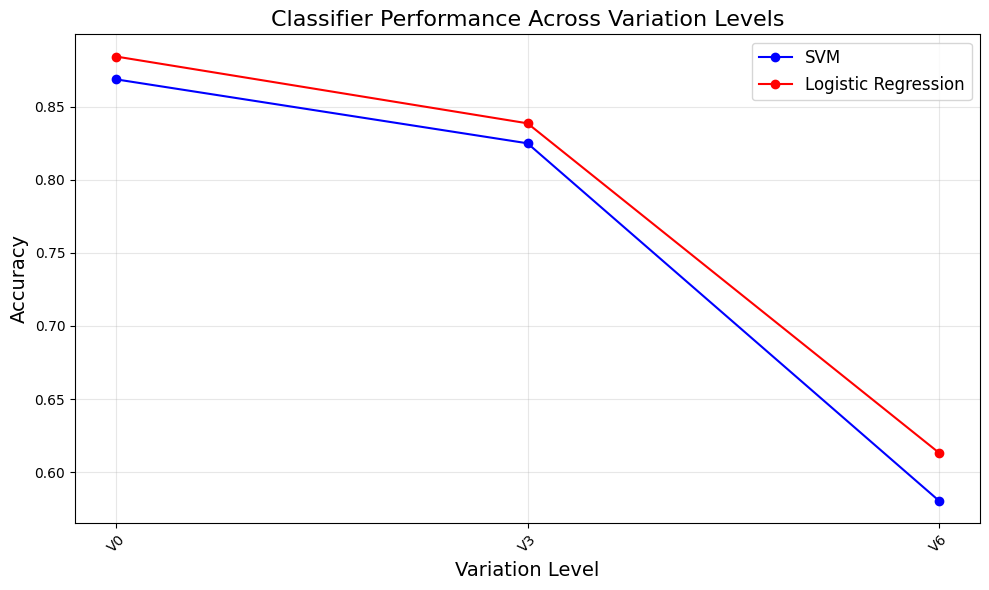

In [ ]:
# Plot performance across variation levels
plt.figure(figsize=(10, 6))
variation_levels = sorted(svm_var_results.keys())
svm_accuracies = [svm_var_results[vl] for vl in variation_levels]
log_accuracies = [log_var_results[vl] for vl in variation_levels]

plt.plot(variation_levels, svm_accuracies, "bo-", label="SVM")
plt.plot(variation_levels, log_accuracies, "ro-", label="Logistic Regression")
plt.xlabel("Variation Level", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Classifier Performance Across Variation Levels", fontsize=16)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Discussion Questions

1. **How does performance change with variation level?** What does this tell us about the neural representation in IT cortex?

2. **Comparing SVM and Logistic Regression**: Which model performs better?

3. **Biological plausibility**: SVM and logistic regression are both linear classifiers. Do you think these models resemble how the brain might decode visual information? Why or why not?


## Conclusion

In this notebook, we explored binary and multi-class classification using PyTorch:

1. **Support Vector Machines (SVMs)**:

   - Implemented binary SVM with hinge loss
   - Extended to multi-class classification using one-vs-all approach
   - Used margin-based optimization to find the decision boundary

2. **Logistic Regression**:

   - Implemented softmax function for probability outputs
   - Used cross-entropy loss to train the model
   - Compared performance with SVM

3. **Effect of Variation**:
   - Evaluated how classification performance changes with increasing stimulus variation
   - Visualized the neural representations in 2D space

Key takeaways:

- Both SVM and logistic regression are effective linear classifiers
- While they share a similar linear architecture (both use nn.Linear), they differ in their loss functions and output interpretations
- SVM maximizes margin, while logistic regression outputs probabilities
- The UniversalProcedure class provides a consistent way to train and evaluate multiple models
- Classification performance decreases with increasing variation level, suggesting that neural representations become more overlapping
